In [2]:
# imports here - notebook by Lisa Podszun
import cv2
import os
import random
import torch
import torchvision as tv
import sklearn.model_selection
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn.functional as F

In [1]:
# loads gwm-mask estimates, the gt masks, the forward and backward optical flows, and corresponding flow images as torch.Tensor
# mask_path: specifies directory for gwm masks

def load_masks(mask_path, ground_truth_path, optical_flow_path, gap, video_choice='blackswan'):
    assert(gap > 0)
    print(f"Selected video: {video_choice}")
    image_names= os.listdir(mask_path + "/" + video_choice)
    optical_flow_names_fwd = os.listdir(f"{optical_flow_path}/Flows_gap{gap}/{video_choice}")
    optical_flow_names_bwd = os.listdir(f"{optical_flow_path}/Flows_gap{(-1)*gap}/{video_choice}")

    optical_flow_image_names_fwd = os.listdir(f"{optical_flow_path}/FlowImages_gap{gap}/{video_choice}")
    optical_flow_image_names_bwd = os.listdir(f"{optical_flow_path}/FlowImages_gap{(-1)*gap}/{video_choice}")
    optical_flow_names_fwd.sort()
    optical_flow_names_bwd.sort()
    optical_flow_image_names_fwd.sort()
    optical_flow_image_names_bwd.sort()
    image_names.sort()
    # return parameters
    list_of_masks = []
    list_of_gt_masks = []
    optical_flows_forward_1 = []
    optical_flows_backward_1 = []
    optical_flows_forward_2 = []
    optical_flows_backward_2 = []
    optical_flow_images_fwd = []
    optical_flow_images_bwd = []
    for image_idx in range(len(image_names)):
        # load masks
        mask = tv.io.read_image(f"{mask_path}/{video_choice}/{image_names[image_idx]}")
        list_of_masks.append(mask)
        # load gt masks 
        gt_mask = tv.io.read_image(f"{ground_truth_path}/{video_choice}/{image_names[image_idx]}")
        gt_mask = gt_mask * (1/255)
        list_of_gt_masks.append(gt_mask)
        if(image_idx < len(image_names)+1 - gap):
            optical_flow_1 = np.fromfile(f"{optical_flow_path}/Flows_gap{gap}/{video_choice}/{optical_flow_names_fwd[image_idx]}", np.float32)            
            # First 3 values are meta data we do not need (H,W)
            optical_flow_1 = torch.from_numpy(np.reshape(optical_flow_1[3:], (mask.shape[1],mask.shape[2]+2, 2)))
            # Optical flow is two values wider than the image
            optical_flow_1 = optical_flow_1[:, 1:-1, :]
            optical_flows_forward_1.append(optical_flow_1)

            
            optical_flow_backward_1 = np.fromfile(f"{optical_flow_path}/Flows_gap{(-1)*gap}/{video_choice}/{optical_flow_names_bwd[image_idx]}", np.float32)
            # First 3 values are meta data we do not need (H,W)
            optical_flow_backward_1 = torch.from_numpy(np.reshape(optical_flow_backward_1[3:], (mask.shape[1],mask.shape[2]+2 , 2)))
            # Optical flow is two values wider than the image
            optical_flow_backward_1 = optical_flow_backward_1[:, 1:-1, :]
            optical_flows_backward_1.append(optical_flow_backward_1)
            # load corresponding flow images
            optical_flow_image_backward = tv.io.read_image(f"{optical_flow_path}/FlowImages_gap{(-1)*gap}/{video_choice}/{optical_flow_image_names_bwd[image_idx]}")

    
    return image_names, list_of_masks, list_of_gt_masks, optical_flows_forward_1, optical_flows_backward_1, optical_flow_images_fwd, optical_flow_images_bwd, video_choice

In [4]:
# warping of optical flow, implementation = SSL-VOS
# Expects image mask of size 1 x H x W
def warp_optical_flow(img_mask, optical_flow):
    dim_x = torch.arange(0, optical_flow.shape[0])
    dim_y = torch.arange(0, optical_flow.shape[1])
    # Add leading one dimension
    base_grid_x, base_grid_y = torch.meshgrid(dim_x, dim_y, indexing='ij')
    base_grid = torch.stack((base_grid_y,base_grid_x))
    base_grid = base_grid.permute((1,2,0))
    
    optical_flow = optical_flow.clone()
    base_grid = base_grid +  optical_flow

    base_grid = base_grid.permute(2,0,1)
    # Normalize grid values to [-1, 1]
    # Image mask has leading 1 dimension
    base_grid[0] = (base_grid[0] / (img_mask.shape[2] * 0.5) - 1) 
    base_grid[1] = (base_grid[1] / (img_mask.shape[1] * 0.5) - 1) 
    base_grid = base_grid.permute(1,2,0)
    img_mask = img_mask.unsqueeze(0)
    img_mask = img_mask.float()
    return F.grid_sample(img_mask, base_grid[None,:,:,:], mode="bilinear")

In [5]:
def iou(mask, gt, thres=0.5):
    mask = mask.clone()
    mask = (mask > thres).float()
    gt = gt.float()
    intersect_pixels = torch.logical_and(mask,gt)
    intersection = torch.sum(intersect_pixels)
    union_pixels = torch.logical_or(mask, gt)
    union = torch.sum(union_pixels)
    return intersection / union

In [6]:
def border_F(mask, gt):
    true_positives = torch.sum(torch.logical_and(mask,gt))
    false_positives = torch.sum(mask) - true_positives
    false_negatives = torch.sum(torch.logical_and(torch.logical_not(mask),gt))
    prec = true_positives / (true_positives + false_positives)
    rec = true_positives / (true_positives + false_negatives)
    return 2 * prec * rec / (prec + rec)


In [7]:
def area_of_mask(mask):
    amount_mask_pixels = torch.sum(mask > 0)
    total_pixels = torch.numel(mask)
    return (amount_mask_pixels/total_pixels)


In [84]:
# we compute occlusion masks for t using optical flows from t+gap -> t (backwards) and t-gap -> t (forwards)
def occlusion_mask(optical_flow_fwd, optical_flow_bwd, alpha1 = 0.01, alpha2 = 0.5): 
    # H W 2
    optical_flow_fwd = optical_flow_fwd.clone()
    optical_flow_bwd = optical_flow_bwd.clone()
    
    dim_x = torch.arange(0, optical_flow_bwd.shape[0])
    dim_y = torch.arange(0, optical_flow_bwd.shape[1])
    base_grid_x, base_grid_y = torch.meshgrid(dim_x, dim_y, indexing='ij')
    base_grid = torch.stack((base_grid_y,base_grid_x))
    base_grid = base_grid.permute((1,2,0))
    
    # Compute occlusion mask forward
    base_grid = base_grid + optical_flow_fwd

    base_grid = base_grid.permute(2,0,1)
    # Normalize grid values to [-1, 1]
    # Image mask has leading 1 dimension
    base_grid[0] = (base_grid[0] / (optical_flow_bwd.shape[1] * 0.5) - 1) 
    base_grid[1] = (base_grid[1] / (optical_flow_bwd.shape[0] * 0.5) - 1) 
    
    base_grid = base_grid.permute(1,2,0)
    optical_flow_bwd_reshaped = optical_flow_bwd.permute(2,0,1)
    sampled_bwd_flow = torch.nn.functional.grid_sample(optical_flow_bwd_reshaped[None,:,:,:], base_grid[None,:,:,:])
    
    sampled_bwd_flow = sampled_bwd_flow.permute(0,2,3,1)
    sampled_bwd_flow = sampled_bwd_flow.squeeze()
    lhs = optical_flow_fwd + sampled_bwd_flow
    lhs.square()
    optical_flow_fwd_copy = optical_flow_fwd.clone()
    rhs = alpha1 * (torch.sum(optical_flow_fwd_copy.square(), dim=2) + torch.sum(sampled_bwd_flow.square(), dim=2)) + alpha2
    occlusion_mask_fwd = (torch.sum(lhs, dim=2) < rhs)
    
    return torch.where(occlusion_mask_fwd,1,0)

In [9]:
# we compute occlusion masks for t using optical flows from t+gap -> t (backwards) and t-gap -> t (forwards)
def occlusion_mask_ref(optical_flow_fwd, optical_flow_bwd, thresh): 
    # H W 2
    optical_flow_fwd = optical_flow_fwd.clone()
    optical_flow_bwd = optical_flow_bwd.clone()
    
    dim_x = torch.arange(0, optical_flow_bwd.shape[0])
    dim_y = torch.arange(0, optical_flow_bwd.shape[1])

    base_grid_x, base_grid_y = torch.meshgrid(dim_x, dim_y, indexing='ij')
    base_grid = torch.stack((base_grid_y,base_grid_x))
    base_grid = base_grid.permute((1,2,0))
    
    # Compute occlusion mask forward
    base_grid_1 = base_grid + optical_flow_fwd

    base_grid_1_norm = base_grid_1.clone()
    base_grid_1_norm = base_grid_1_norm.permute(2,0,1)
    # Normalize grid values to [-1, 1]
    # Image mask has leading 1 dimension

    base_grid_1_norm[0] = (2 * base_grid_1_norm[0] / (optical_flow_bwd.shape[0] - 1) - 1) 
    base_grid_1_norm[1] = (2 * base_grid_1_norm[1] / (optical_flow_bwd.shape[1] - 1) - 1) 
    
    mask = (base_grid_1_norm[0] > -1) & (base_grid_1_norm[1] > -1) & (base_grid_1_norm[0] < 1) & (base_grid_1_norm[1] < 1)
    base_grid_1_norm = base_grid_1_norm.permute(1,2,0)

    optical_flow_bwd_reshaped = optical_flow_bwd.permute(2,0,1)

    sampled_bwd_flow = torch.nn.functional.grid_sample(optical_flow_bwd_reshaped[None,:,:,:], base_grid_1_norm[None,:,:,:], mode="bilinear", align_corners=True)
    

    sampled_bwd_flow = sampled_bwd_flow.permute(0,2,3,1)
    sampled_bwd_flow = sampled_bwd_flow.squeeze()

    base_grid_2 = base_grid_1 + sampled_bwd_flow

    error = (base_grid - base_grid_2)
    
    error = error.norm(dim=2)

    
    return torch.where(error > thresh, 1, 0), mask

In [10]:
dim_x = torch.Tensor([1,2,3])
dim_y = torch.Tensor([1,2,3,4])
# Add leading one dimension
base_grid = torch.stack(torch.meshgrid(dim_x, dim_y, indexing='ij'))
base_grid = base_grid.permute((1,2,0))

In [11]:

def save_as_image(mask, category, gap, video, file_name):
    mask = mask.clone()
    mask = mask.squeeze()
    mask = mask.numpy()
    mask = mask.astype("uint8")
    mask_img = Image.fromarray(mask.astype("uint8"))
    os.makedirs(f"./masks/Optical_flow_warping/{category}_gap_{gap}/{video}/", exist_ok = True)
    mask_img.save(f"./masks/Optical_flow_warping/{category}_gap_{gap}/{video}/{file_name}")

In [12]:
# own implementation experiment for optical flow warping
def warp_mask_to_flow(img_mask, optical_flow):
    # [1,480,854]

    img_mask = img_mask.squeeze()
    optical_flow = optical_flow.squeeze()
    warped_mask = torch.zeros_like(img_mask)
    for i in range(img_mask.shape[1]):
        for j in range(img_mask.shape[0]):
            if (img_mask[j, i] > 0.99):
                u,v = round(j + optical_flow[j , i, 1].item()), round(i + optical_flow[j , i, 0].item())
                # Check whether the optical flow shifted pixel location is in the image
                if (u > 0 and u < 480 and v > 0 and v < 854):
                    warped_mask[u, v] = img_mask[j,i]
    return warped_mask

In [13]:
# get correct final mask
def get_correct_mask(mask, gt):
    iou_og_mask = iou(mask,gt)
    iou_flipped_mask = iou((1-mask), gt)
    if (iou_og_mask < iou_flipped_mask):
        return (1-mask)
    return mask

In [101]:
# Load random video here
davis_path = "./masks"
stv2_path = "./masks_stv2/"
davis_gt_path = "./masks/Annotations/480p/"
stv2_gt_path = "./masks_stv2/GroundTruth/"
optical_davis = "../data/DAVIS2016"
optical_stv2 = "../data/SegTrackv2"
gap = 1


image_names, video_mask_estimates, gt_video_masks, optical_flows_forward_1, optical_flows_backward_1, optical_flow_images_fwd, optical_flow_images_bwd, video = load_masks(stv2_path, stv2_gt_path, optical_stv2, gap, video_choice='birdfall')

_, _, _, optical_flows_forward_2, optical_flows_backward_2, _, _, _ = load_masks(stv2_path, stv2_gt_path, optical_stv2, 2, video_choice='birdfall')

Selected video: birdfall
Selected video: birdfall


In [15]:
# Refined masks after warping

iou_sum_refined = 0
iou_sum_fwd = 0
iou_sum_bwd = 0
area_gt_mask = 0
area_mask_estimate = 0
area_fwd_warp = 0
area_bwd_warp = 0
area_refined_mask = 0

for idx in range(len(video_mask_estimates)-gap):
    video_mask_estimates[idx]       = get_correct_mask(video_mask_estimates[idx],     gt_video_masks[idx])
    video_mask_estimates[idx+gap]   = get_correct_mask(video_mask_estimates[idx+gap], gt_video_masks[idx+gap])

    occ_fwd               = occlusion_mask(optical_flows_forward[idx], optical_flows_backward[idx]) 
    occ_bwd              = occlusion_mask(optical_flows_backward[idx], optical_flows_forward[idx])

    img_mask_prev_1                   = torch.logical_and(video_mask_estimates[idx], occ_fwd)
    img_mask_next_1                   = torch.logical_and(video_mask_estimates[idx+gap], torch.logical_not(occ_bwd))

    warp_estimate_bwd_1               = torch.squeeze(warp_optical_flow(img_mask= img_mask_next_1, optical_flow= optical_flows_backward[idx]))
    warp_estimate_fwd_1               = torch.squeeze(warp_optical_flow(img_mask= img_mask_prev_1, optical_flow=optical_flows_forward[idx]))

    save_as_image(video_mask_estimates[idx], "test", "test", video, image_names[idx])
    save_as_image(warp_estimate_fwd_1, "warp_estimate_fwd",gap, video, image_names[idx])
    save_as_image(warp_estimate_bwd_1, "warp_estimate_bwd",gap, video, image_names[idx])

    mask_estimate_sq                = torch.squeeze(video_mask_estimates[idx])
    refined_mask                    = refine_masks(mask_estimate_sq, warp_estimate_fwd_1, warp_estimate_bwd_1)
    refined_mask                    = refined_mask * 255

    save_as_image(refined_mask, "refined_masks", gap, video, image_names[idx])

    iou_sum_refined                 += iou(refined_mask, gt_video_masks[idx])
    iou_sum_fwd                     += iou(warp_estimate_fwd_1, gt_video_masks[idx+gap])
    iou_sum_bwd                     += iou(warp_estimate_bwd_1, gt_video_masks[idx])

    area_fwd_warp                   += area_of_mask(warp_estimate_fwd_1)
    area_bwd_warp                   += area_of_mask(warp_estimate_bwd_1)
    area_refined_mask               += area_of_mask(refined_mask)

print("IOU over entire video with forward warped masks:", iou_sum_fwd/(len(video_mask_estimates)-gap))
print("IOU over entire video with backward warped masks:", iou_sum_bwd/(len(video_mask_estimates)-gap))
print("IOU over entire video with refined masks:", iou_sum_refined/(len(video_mask_estimates)-gap))
print("\n")
print("Average area % of gt mask in video:", area_fwd_warp/(len(video_mask_estimates)-gap))
print("Average area % of original mask estimate in video:", area_bwd_warp/(len(video_mask_estimates)-gap))
print("Average area % of forward warped mask in video:", area_fwd_warp/(len(video_mask_estimates)-gap))
print("Average area % of backward warped mask in video:", area_bwd_warp/(len(video_mask_estimates)-gap))
print("Average area % of refined mask in video:", area_refined_mask/(len(video_mask_estimates)-gap))

NameError: name 'optical_flows_forward' is not defined

In [103]:
iou_sum_2 = 0
border_sum_og = 0
# Original GWM mask estimate for comparison
for idx in range(len(video_mask_estimates)-gap):
    mask_estimate_sq = torch.squeeze(video_mask_estimates[idx])
    iou_sum_2 += max(iou(mask_estimate_sq, gt_video_masks[idx]), iou(torch.logical_xor(mask_estimate_sq, torch.ones_like(mask_estimate_sq)), gt_video_masks[idx]))
    #border_sum_og += max(border_F(mask_estimate_sq, gt_video_masks[idx]), border_F(torch.logical_xor(mask_estimate_sq, torch.ones_like(mask_estimate_sq)), gt_video_masks[idx]))
print("IOU over entire video with original GWM estimate:", iou_sum_2/(len(video_mask_estimates)-gap))
#print("Border F over entire video with original GWM estimate:", border_sum_og/(len(video_mask_estimates)-gap))


IOU over entire video with original GWM estimate: tensor(0.6257)


In [104]:

# grid search for alpha1, alpha2, mask prop. and refinement with occlusions for t->t+1 and t+1->t 
iou_sum = 0
i = 1

alpha1 = 0.01
alpha2 = 0.5

alpha1_best_t_1 = 0
alpha2_best_t_1 = 0

alpha1_best_t = 0
alpha2_best_t = 0

iou_best_t_1 = 0
iou_best_t = 0

border_f_t_best  = 0
border_f_t_1_best  = 0

iou_sum = 0
iou_sum_t_1 = 0
iou_sum_t = 0
"""
for i in range(1,20):
    for j in [x/100.0 for x in range(5,50,5)]:
        iou_sum = 0
        iou_sum_t_1 = 0
        iou_sum_t = 0
        border_f_sum_t_1 = 0
border_f_sum_t = 0
"""
for idx in range(len(video_mask_estimates)-gap):
    video_mask_estimates[idx]       = get_correct_mask(video_mask_estimates[idx],     gt_video_masks[idx])
    video_mask_estimates[idx+gap]   = get_correct_mask(video_mask_estimates[idx+gap], gt_video_masks[idx+gap])

    occ_fwd                         = occlusion_mask(optical_flows_forward_1[idx], optical_flows_backward_1[idx], alpha1=alpha1, alpha2=alpha2)
    occ_bwd                         = occlusion_mask(optical_flows_backward_1[idx], optical_flows_forward_1[idx],  alpha1=alpha1, alpha2=alpha2) 

    img_mask_prev                   = torch.logical_and(video_mask_estimates[idx], occ_fwd)
    
    img_mask_next                   = torch.logical_and(video_mask_estimates[idx+gap], torch.logical_not(occ_bwd))

    warp_estimate_fwd               = torch.squeeze(warp_optical_flow(img_mask= img_mask_prev, optical_flow=optical_flows_backward_1[idx]))
    warp_estimate_bwd               = torch.squeeze(warp_optical_flow(img_mask= img_mask_next, optical_flow= optical_flows_forward_1[idx]))

    # OR WITH original mask
    refined_mask_t                  = torch.logical_or(warp_estimate_bwd, video_mask_estimates[idx])
    refined_mask_t_1                = torch.logical_or(warp_estimate_fwd, video_mask_estimates[idx+gap])

    iou_sum_t_1 += iou(refined_mask_t_1, gt_video_masks[idx+gap].squeeze())
    iou_sum_t += iou(refined_mask_t, gt_video_masks[idx].squeeze()) 

    #border_f_sum_t += border_F(refined_mask_t, gt_video_masks[idx].squeeze())
    #border_f_sum_t_1 += border_F(refined_mask_t_1, gt_video_masks[idx+gap].squeeze())

iou_over_video_t_1 = iou_sum_t_1 / (len(video_mask_estimates)-gap)
iou_over_video_t = iou_sum_t / (len(video_mask_estimates)-gap)

#border_f_sum_t = border_f_sum_t / (len(video_mask_estimates)-gap)
#border_f_sum_t_1 = border_f_sum_t_1 / (len(video_mask_estimates)-gap)

if(iou_best_t_1 < iou_over_video_t_1): 
    alpha1_best_t_1 = alpha1 * i
    #alpha2_best_t_1 = alpha2 - j
    iou_best_t_1 = iou_over_video_t_1
    #border_f_t_1_best = border_f_sum_t_1

if(iou_best_t < iou_over_video_t):
    alpha1_best_t = alpha1 * i
    alpha2_best_t = alpha2 - i
    iou_best_t = iou_over_video_t
    #border_f_t_best = border_f_sum_t

#print("Best alpha1 for t + 1", alpha1_best_t_1)
#print("Best alpha2 for t + 1", alpha2_best_t_1)
print("Best IOU for t+1", iou_best_t_1)
#print("Border F for t+1", border_f_t_1_best)

Best IOU for t+1 tensor(0.0066)


In [105]:
# grid search for alpha1, alpha2, mask prop. and refinement with occlusions for t->t+1 and t+1->t 
iou_sum = 0
i = 1
gap = 2

alpha1 = 0.01
alpha2 = 0.05

alpha1_best_t_1 = 0
alpha2_best_t_1 = 0

alpha1_best_t = 0
alpha2_best_t = 0

iou_best_t_1 = 0
iou_best_t = 0

border_f_t_best  = 0
border_f_t_1_best  = 0

def refinement_voting(mask, propagated_masks, occlusion_masks,factor=1.5):
    weighted_sum = mask
    weighted_sum = weighted_sum.float()/255.0
    normalizer = torch.ones_like(mask.float())
    for i in range(len(propagated_masks)):
        weight = (1/pow(factor,i))
        weighted_sum    += weight * propagated_masks[i][0]                                            
        weighted_sum    += weight * propagated_masks[i][1]
        normalizer      += weight * occlusion_masks[i][0]
        normalizer      += weight * occlusion_masks[i][1]
    return (weighted_sum/normalizer) > 0.5 


iou_sum = 0
iou_sum_t_1 = 0
iou_sum_t = 0
border_f_sum_t_1 = 0
border_f_sum_t = 0
"""

for i in range(1,20):
    for j in [x/100.0 for x in range(5,50,5)]:
        iou_sum = 0
        iou_sum_t_1 = 0
        iou_sum_t = 0
        border_f_sum_t_1 = 0
        border_f_sum_t = 0
        """
for idx in range(gap,len(video_mask_estimates)-gap):
    video_mask_estimates[idx]         = get_correct_mask(video_mask_estimates[idx], gt_video_masks[idx])
    video_mask_estimates[idx-1]       = get_correct_mask(video_mask_estimates[idx-1], gt_video_masks[idx-1])
    video_mask_estimates[idx+1]       = get_correct_mask(video_mask_estimates[idx+1], gt_video_masks[idx+1])

    video_mask_estimates[idx-2]       = get_correct_mask(video_mask_estimates[idx-2], gt_video_masks[idx-2])
    video_mask_estimates[idx+2]       = get_correct_mask(video_mask_estimates[idx+2], gt_video_masks[idx+2])

    occ_fwd_1                         = occlusion_mask(optical_flows_forward_1[idx-1], optical_flows_backward_1[idx-1], alpha1=alpha1 * i, alpha2=alpha2 )
    occ_bwd_1                         = occlusion_mask(optical_flows_backward_1[idx-1], optical_flows_forward_1[idx-1],  alpha1=alpha1 * i, alpha2=alpha2 - i) 

    img_mask_prev_1                   = torch.logical_and(video_mask_estimates[idx-1], occ_fwd)
    # occ_bwd seems inverted compared to paper, but fomula is the same
    img_mask_next_1                   = torch.logical_and(video_mask_estimates[idx+1], occ_bwd)

    warp_estimate_fwd_1               = torch.squeeze(warp_optical_flow(img_mask= img_mask_prev_1, optical_flow= optical_flows_forward_1[idx-1]))
    warp_estimate_bwd_1               = torch.squeeze(warp_optical_flow(img_mask= img_mask_next_1, optical_flow= optical_flows_backward_1[idx]))

    occ_fwd_warped_1                  = torch.squeeze(warp_optical_flow(img_mask= occ_fwd_1[None,:,:], optical_flow=optical_flows_backward_1[idx-1]))
    occ_bwd_warped_1                  = torch.squeeze(warp_optical_flow(img_mask= occ_bwd_1[None,:,:], optical_flow=optical_flows_forward_1[idx]))

    occ_fwd_2                         = occlusion_mask(optical_flows_forward_2[idx-2], optical_flows_backward_2[idx-2], alpha1=alpha1 * i, alpha2=alpha2 )
    occ_bwd_2                         = occlusion_mask(optical_flows_backward_2[idx], optical_flows_forward_2[idx],  alpha1=alpha1 * i, alpha2=alpha2 - i) 

    img_mask_prev_2                   = torch.logical_and(video_mask_estimates[idx-2], occ_fwd_2)
    # occ_bwd seems inverted compared to paper, but fomula is the same
    img_mask_next_2                   = torch.logical_and(video_mask_estimates[idx+2], torch.logical_not(occ_bwd_2))

    warp_estimate_fwd_2               = torch.squeeze(warp_optical_flow(img_mask= img_mask_prev_2, optical_flow=optical_flows_forward_2[idx-2]))
    warp_estimate_bwd_2               = torch.squeeze(warp_optical_flow(img_mask= img_mask_next_2, optical_flow= optical_flows_backward_2[idx]))

    occ_fwd_warped_2                  = torch.squeeze(warp_optical_flow(img_mask= occ_fwd_2[None,:,:], optical_flow=optical_flows_forward_2[idx-2]))
    occ_bwd_warped_2                  = torch.squeeze(warp_optical_flow(img_mask= torch.logical_not(occ_bwd_2)[None,:,:], optical_flow=optical_flows_backward_2[idx]))           

    propagated_masks = [(warp_estimate_fwd_1, warp_estimate_bwd_1) ] #, (warp_estimate_fwd_2, warp_estimate_bwd_2)]
    occlusion_masks = [(occ_bwd_warped_1, occ_fwd_warped_1)] #, (occ_bwd_2, occ_fwd_2)]

    # OR WITH original mask
    refined_mask_t                  = refinement_voting(video_mask_estimates[idx], propagated_masks, occlusion_masks, 2.0)

    iou_sum_t += iou(refined_mask_t, gt_video_masks[idx].squeeze()) 

    #border_f_sum_t += border_F(refined_mask_t, gt_video_masks[idx].squeeze())

iou_over_video_t = iou_sum_t / (len(video_mask_estimates)-gap)

#border_f_sum_t = border_f_sum_t / (len(video_mask_estimates)-gap)

if(iou_best_t < iou_over_video_t):
    alpha1_best_t = alpha1 * i
    #alpha2_best_t = alpha2 - j
    alpha1_best_t_1 = alpha1 * i
    #alpha2_best_t_1 = alpha2 - j
    iou_best_t = iou_over_video_t
    border_f_t_best = border_f_sum_t

#print("Best alpha1 for t", alpha1_best_t)
#print("Best alpha2 for t", alpha2_best_t)
#print("Best alpha1 for t + 1", alpha1_best_t_1)
#print("Best alpha2 for t + 1", alpha2_best_t_1)
print("Best IOU for t", iou_best_t)
#print("Border F for t", border_f_t_best)

Best IOU for t tensor(0.0053)


In [54]:
# ignore
# visualizing function here

def visualize_images(images, gap):
    figure = plt.figure(figsize=(20,20* len(images)))
    for i in range(len(images)):
        figure.add_subplot(1,len(images),i+1)
        plt.axis("off")
        plt.title(images[i][0])
        if (images[i][2] == 'gray'):
            plt.imshow(images[i][1], cmap="gray")
        else:
            plt.imshow(images[i][1])
    plt.show()

Error values tensor([1.5397e-04, 2.8420e-04, 9.5913e-04,  ..., 1.6201e+01, 1.6290e+01,
        1.6384e+01])
Error values tensor([4.7105e-04, 7.5388e-04, 1.2139e-03,  ..., 1.5569e+01, 1.5590e+01,
        1.5603e+01])


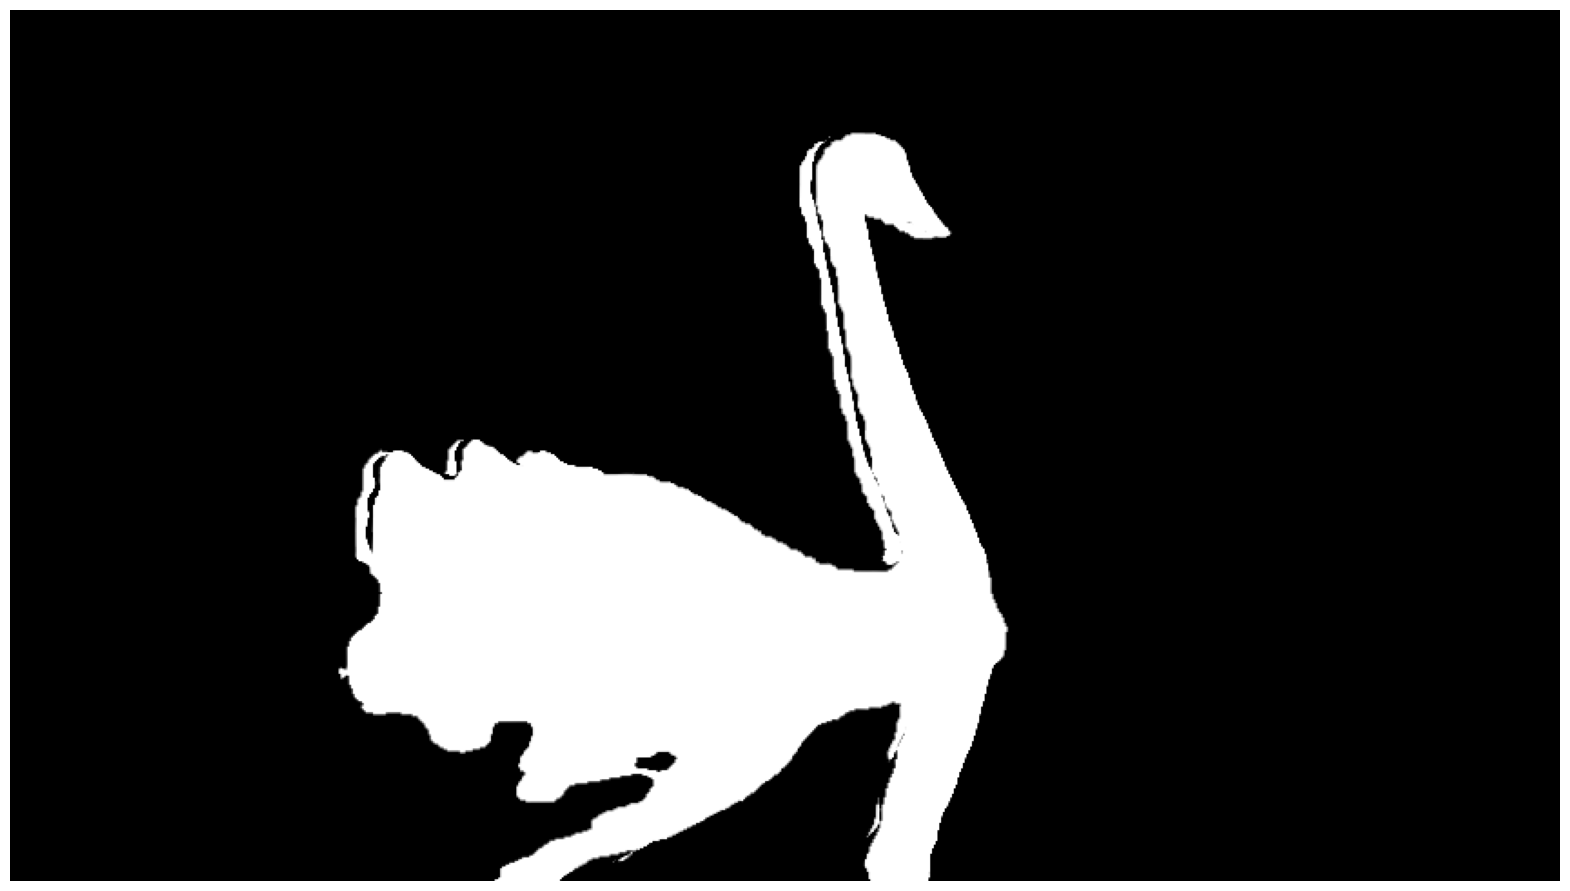

In [57]:
# Visualization example
idx = 10
# for forward flow: idx tells us the starting image and the gap the flow target

# for backward flow: idx tells us the target image and the gap the starting image

# occlusion masks fwd and bwd for t-1 -> t
occ_bwd = occlusion_mask(optical_flows_forward_1[idx-1], optical_flows_backward_1[idx-1], alpha1=0.01, alpha2=0.5) 
occ_fwd = occlusion_mask(optical_flows_backward_1[idx-1], optical_flows_forward_1[idx-1], alpha1=0.01, alpha2=0.5)

warp_estimate = torch.squeeze(warp_optical_flow(img_mask= video_mask_estimates[idx], optical_flow=optical_flows_backward_1[idx-1]))

occ_bwd_ref, mask1 = occlusion_mask_ref(optical_flows_forward_1[idx-1], optical_flows_backward_1[idx-1], thresh= 1.0)
occ_fwd_ref, mask2 = occlusion_mask_ref(optical_flows_backward_1[idx-1], optical_flows_forward_1[idx-1], thresh= 1.0)

img_mask_prev_1 = torch.logical_and(video_mask_estimates[idx-1], occ_fwd)
img_mask_next_1 = torch.logical_and(video_mask_estimates[idx+1], occ_bwd)

warp_estimate_tp1_to_t_gap1 = torch.squeeze(warp_optical_flow(img_mask= img_mask_prev_1,optical_flow= optical_flows_forward_1[idx]))
warp_estimate_tm1_to_t_gap1 = torch.squeeze(warp_optical_flow(img_mask= img_mask_next_1, optical_flow=optical_flows_backward_1[idx-1]))

refined_mask_t = torch.logical_or(warp_estimate_bwd_1, video_mask_estimates[idx])
refined_mask_t_1 = torch.logical_or(warp_estimate_fwd_1, video_mask_estimates[idx+gap])

propagated_masks = [(warp_estimate_tm1_to_t_gap1, warp_estimate_tp1_to_t_gap1)]
occlusion_masks = [(occ_fwd, occ_bwd)]

refined_mask_t_voted = refinement_voting(video_mask_estimates[idx], propagated_masks=propagated_masks, occlusion_masks=occlusion_masks, factor=1.5)

mask_estimate_sq = torch.squeeze(video_mask_estimates[idx])




iou_value = iou(gt_video_masks[idx+gap], warp_estimate_fwd_1)
images = [("", warp_estimate, "gray")]
visualize_images(images, gap)
